In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

/Users/mayoudong/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
train = pd.read_csv('~/Downloads/train.csv')
X_test = pd.read_csv('~/Downloads/test.csv')

In [3]:
print(train.shape)
print(train.columns)
print(train.keys())

(42000, 785)
Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)
Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)


In [4]:
X_train = train.drop(['label'], axis = 1)
Y_train = train["label"]

In [5]:
print(Y_train.shape)
print(X_train.shape)
print(X_train.values)
print(Y_train.values)
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

(42000,)
(42000, 784)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[1 0 1 ... 7 6 9]


In [6]:
class DataReader():
    
    def __init__(self, length, width, depth, nb_classes):
        self.i = 0
        self.length = length
        self.width = width
        self.depth = depth
        self.nb_classes = nb_classes
        
        self.training_images = None
        self.training_labels = None
        
        self.test_images = None
        self.test_labels = None
        
    #train_data (data_size, picturepixels)
    def set_up_images(self, train_data):
        self.training_images = train_data.values.reshape(-1, self.length, self.width, self.depth)
        self.training_labels = np.eye(self.nb_classes)[Y_train.values]
        
        print(self.training_images.shape)
        print(self.training_labels.shape)
        print("Setting Up Training Images and Labels")
    
    def call_setup(self, all_train_batches):
        self.set_up_images(all_train_batches)
    
    def next_batch(self, batch_size):
        x = self.training_images[self.i:self.i+batch_size]
        y = self.training_labels[self.i:self.i+batch_size]
        self.i = (self.i + batch_size) % len(self.training_images)
        return x, y
    
    
    

In [7]:
DR = DataReader(28, 28, 1, 10)
DR.call_setup(X_train)

(42000, 28, 28, 1)
(42000, 10)
Setting Up Training Images and Labels


Creating the Model¶

In [10]:
class Model():
    def __init__(self, train_images, train_labels):
        self.train = None
        self.y_pred = None
        self.train_images = train_images
        self.train_labels = train_labels
        self.x = None
        self.y = None
        self.hold_prob = None
    
    def create_placeholder(self):
        inputshape = [None, self.train_images.shape[1], self.train_images.shape[2], self.train_images.shape[3]]
        labelshape = [None, self.train_labels.shape[1]]
        self.x = tf.placeholder(tf.float32,shape=inputshape)
        self.y = tf.placeholder(tf.float32,shape=labelshape)
        self.hold_prob = tf.placeholder(tf.float32)
        #return x, y, hold_prob
    
    def init_weights(self, shape):
        init_random_dist = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(init_random_dist)

    def init_bias(self, shape):
        init_bias_vals = tf.constant(0.1, shape=shape)
        return tf.Variable(init_bias_vals)
    
    def conv2d(self, x, W):
        return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

    def max_pool_2by2(self, x):
        return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                              strides=[1, 2, 2, 1], padding='SAME')

    def convolutional_layer(self, input_x, shape):
        W = self.init_weights(shape)
        b = self.init_bias([shape[3]])
        return tf.nn.relu(self.conv2d(input_x, W) + b)

    def normal_full_layer(self, input_layer, size):
        input_size = int(input_layer.get_shape()[1])
        W = self.init_weights([input_size, size])
        b = self.init_bias([size])
        return tf.matmul(input_layer, W) + b
    
    def build_model(self):
        self.create_placeholder()
        convo_1 = self.convolutional_layer(self.x,shape=[4,4,1,32])
        convo_1_pooling = self.max_pool_2by2(convo_1)
        convo_2 = self.convolutional_layer(convo_1_pooling,shape=[4,4,32,64])
        convo_2_pooling = self.max_pool_2by2(convo_2)
        convo_2_flat = tf.reshape(convo_2_pooling,[-1, 7 * 7 * 64])
        full_layer_one = tf.nn.relu(self.normal_full_layer(convo_2_flat,1024))
        full_one_dropout = y_pred(full_layer_one,keep_prob=self.hold_prob)
        self.y_pred = self.normal_full_layer(full_one_dropout,10)
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.y ,logits=self.y_pred))
        optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        self.train = optimizer.minimize(cross_entropy)

In [12]:
Mymodel = Model(DR.training_images, DR.training_labels)
Mymodel.build_model()

In [19]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(1000):
        batch = DR.next_batch(100)
        sess.run(Mymodel.train, feed_dict={Mymodel.x: batch[0], Mymodel.y: batch[1], Mymodel.hold_prob: 0.5})
        if (i % 10 == 0):
            print(i)
    print(X_test.shape)
    test_x = X_test.values.reshape(28000, 28, 28, 1)
    print(Mymodel)
    Mymodel.y_pred = sess.run(Mymodel.y_pred, feed_dict={Mymodel.x: test_x, Mymodel.hold_prob: 1})
    print(Mymodel.y_pred)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
(28000, 784)
[[ 22.993572   -12.133835   121.311295   ... -12.593657     3.964936
  -19.702015  ]
 [ 72.215034   -59.86487      6.6718297  ...  -2.9259427  -11.377503
    3.3662803 ]
 [-24.7682       1.915975     7.820847   ...   3.3839717    9.317007
   51.59917   ]
 ...
 [-17.03285    -17.386726   -13.484908   ...   2.049852    11.149509
   12.540917  ]
 [  1.1276504  -38.89111    -37.12119    ...  25.419815    17.310036
   71.84401   ]
 [  0.47312123  -2.7598608   93.43433    ... -18.252129    27.623747
   -5.6012673 ]]


In [22]:
print(X_test.shape)
print(Mymodel.y_pred)
print(Mymodel.y_pred.shape)

(28000, 784)
[[ 22.993572   -12.133835   121.311295   ... -12.593657     3.964936
  -19.702015  ]
 [ 72.215034   -59.86487      6.6718297  ...  -2.9259427  -11.377503
    3.3662803 ]
 [-24.7682       1.915975     7.820847   ...   3.3839717    9.317007
   51.59917   ]
 ...
 [-17.03285    -17.386726   -13.484908   ...   2.049852    11.149509
   12.540917  ]
 [  1.1276504  -38.89111    -37.12119    ...  25.419815    17.310036
   71.84401   ]
 [  0.47312123  -2.7598608   93.43433    ... -18.252129    27.623747
   -5.6012673 ]]
(28000, 10)


In [23]:
with tf.Session() as sess:
    result = sess.run(tf.argmax(Mymodel.y_pred, 1))
    print(result)

[2 0 9 ... 3 9 2]


In [24]:
print(result.shape)

(28000,)


In [25]:
res = pd.Series(result, name = "Label")
submission = pd.concat([pd.Series(range(1, 28001), name = "ImageId"), res], axis = 1)
submission.to_csv("Submission.csv", index = False)

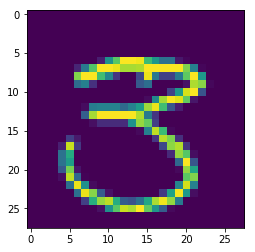

In [33]:
plt.imshow(DR.training_images[7].reshape(28,28))
plt.show()